In [51]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.applications import InceptionV3,Xception
from keras.models import Model
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Dense,Input,Flatten,Dropout
from keras.applications.inception_v3 import preprocess_input
from keras import models, layers, optimizers
import matplotlib.pylab as plt
from sklearn.metrics import confusion_matrix
import itertools
import cv2


In [44]:
cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
labels = pd.read_csv("../input/10-monkey-species/monkey_labels.txt", names=cols, skiprows=1)
labels

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [2]:
img_h=150
img_w=150
img_c=3
bs=32


In [3]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
train_gen=train_datagen.flow_from_directory(
    '../input/10-monkey-species/training/training/',
    target_size=(img_h,img_w),
    batch_size=bs,
    class_mode='categorical',
    seed=1
)
val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
val_gen=val_datagen.flow_from_directory(
    '../input/10-monkey-species/validation/validation',
    target_size=(img_h,img_w),
    batch_size=bs,
    class_mode='categorical',
    seed=1
)
# next(val_gen)[0].shape

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [7]:
data_len=train_gen.samples

In [4]:
base_model=InceptionV3(weights='imagenet',include_top=False)

base_model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
______________________

In [75]:
for layer in base_model.layers:
        layer.trainable = False
X=base_model.output
X = layers.GlobalAveragePooling2D()(X)
X=Dense(512,activation='relu')(X)
X=Dropout(0.5)(X)
X=Dense(512,activation='relu')(X)
X=Dropout(0.5)(X)
out=Dense(10,activation='softmax')(X)
model=Model(inputs=base_model.input,outputs=out)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [76]:
callbacks=[
    EarlyStopping(
        patience=4,
        monitor='val_accuracy',
    ),
    
    ReduceLROnPlateau(monitor='loss',
                     factor=0.1,
                     patience=2,
                     cooldown=2,
                     verbose=1)
]
batches_per_epoch = data_len//bs
lr_decay = (1./0.8 -1)/batches_per_epoch
opt = Adam(lr=1e-3,beta_1=0.9,beta_2=0.999,decay=lr_decay)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])


In [77]:
history=model.fit_generator(train_gen,
        epochs=15,
        validation_data=val_gen,
        steps_per_epoch=batches_per_epoch,                    
        callbacks=callbacks)

Epoch 1/15
34/34 [==============================] - 74s 2s/step - loss: 2.4874 - accuracy: 0.1707 - val_loss: 1.8185 - val_accuracy: 0.4265
Epoch 2/15
34/34 [==============================] - 67s 2s/step - loss: 1.9228 - accuracy: 0.3349 - val_loss: 0.4027 - val_accuracy: 0.5993
Epoch 3/15
34/34 [==============================] - 64s 2s/step - loss: 1.6043 - accuracy: 0.4409 - val_loss: 1.1728 - val_accuracy: 0.6875
Epoch 4/15
34/34 [==============================] - 70s 2s/step - loss: 1.3623 - accuracy: 0.5478 - val_loss: 0.2822 - val_accuracy: 0.7390
Epoch 5/15
34/34 [==============================] - 72s 2s/step - loss: 1.1913 - accuracy: 0.6116 - val_loss: 0.9317 - val_accuracy: 0.7610
Epoch 6/15
34/34 [==============================] - 67s 2s/step - loss: 1.0597 - accuracy: 0.6538 - val_loss: 0.3345 - val_accuracy: 0.7353
Epoch 7/15
34/34 [==============================] - 69s 2s/step - loss: 0.9929 - accuracy: 0.6838 - val_loss: 0.7553 - val_accuracy: 0.7574
Epoch 8/15
34/34 [==

In [78]:
train_gen1=train_datagen.flow_from_directory(
    '../input/10-monkey-species/training/training/',
    target_size=(280,280),
    batch_size=bs,
    class_mode='categorical',
    seed=1
)
val_gen1=val_datagen.flow_from_directory(
    '../input/10-monkey-species/validation/validation',
    target_size=(280,280),
    batch_size=bs,
    class_mode='categorical',
    seed=1
)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [79]:
history=model.fit_generator(train_gen1,
        epochs=15,
        validation_data=val_gen1,
        steps_per_epoch=batches_per_epoch,                    
        callbacks=callbacks)

Epoch 1/15
34/34 [==============================] - 74s 2s/step - loss: 0.4354 - accuracy: 0.8715 - val_loss: 0.2499 - val_accuracy: 0.9301
Epoch 2/15
34/34 [==============================] - 69s 2s/step - loss: 0.3652 - accuracy: 0.8827 - val_loss: 0.2129 - val_accuracy: 0.9522
Epoch 3/15
34/34 [==============================] - 67s 2s/step - loss: 0.3162 - accuracy: 0.9006 - val_loss: 0.2095 - val_accuracy: 0.9228
Epoch 4/15
34/34 [==============================] - 71s 2s/step - loss: 0.3229 - accuracy: 0.9017 - val_loss: 0.2533 - val_accuracy: 0.9265
Epoch 5/15
34/34 [==============================] - 68s 2s/step - loss: 0.3118 - accuracy: 0.9205 - val_loss: 0.2274 - val_accuracy: 0.9485
Epoch 6/15
34/34 [==============================] - 68s 2s/step - loss: 0.2093 - accuracy: 0.9343 - val_loss: 0.1300 - val_accuracy: 0.9485


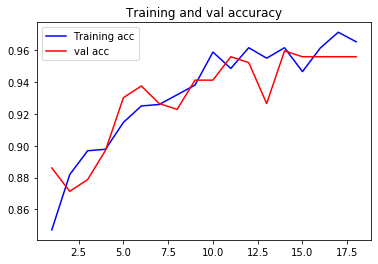

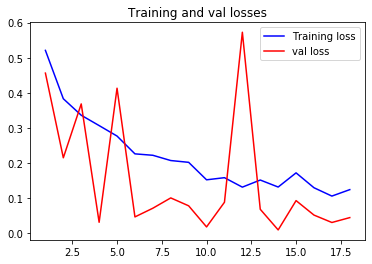

In [13]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.title('Training and val accuracy')
plt.plot(epochs,acc,'blue',label='Training acc')
plt.plot(epochs,val_acc,'red',label='val acc')
plt.legend()

plt.figure()
plt.title('Training and val losses')
plt.plot(epochs,loss,'blue',label='Training loss')
plt.plot(epochs,val_loss,'red',label='val loss')
plt.legend()
plt.show()

In [80]:
temp_val_gen=val_datagen.flow_from_directory(
    '../input/10-monkey-species/validation/validation',
    target_size=(280,280),
    batch_size=272,
    class_mode='categorical',
    seed=1
)
    

Found 272 images belonging to 10 classes.


In [81]:
x_val,y_true=next(temp_val_gen)

In [82]:
y_pred=model.predict(x_val)

In [66]:
y_pred.shape

(272, 10)

In [83]:
# predictions = [i.argmax() for i in y_pred]
# y_true = [i.argmax() for i in test_labels]
# predictions
y_pred=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_true,axis=1)

In [45]:
def plot_confusion_matrix(cm, target_names,title='Confusion matrix',cmap=None,normalize=False):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float32') / cm.sum(axis=1)
        cm = np.round(cm,2)
        

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel("Predicted label\naccuracy={:0.4f}\n misclass={:0.4f}".format(accuracy, misclass))
    plt.show()

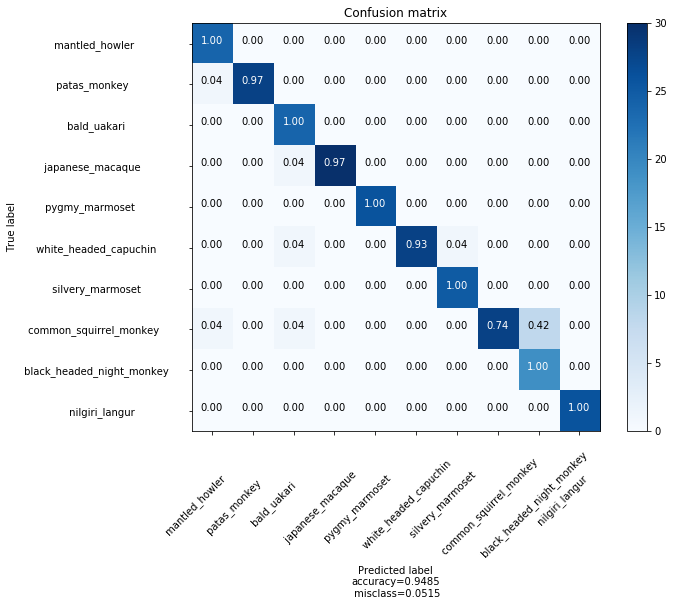

In [86]:
lbls = labels['Common Name']
cm = confusion_matrix(y_pred, y_true)
plot_confusion_matrix(cm, normalize=True, target_names=lbls)

In [84]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average=None)

array([0.96      , 0.98245614, 0.94117647, 0.98360656, 1.        ,
       0.96551724, 0.98039216, 0.84848485, 0.82608696, 1.        ])

In [85]:
cm

array([[22,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 26,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0, 23,  0,  0,  0,  0,  0,  2,  1],
       [ 0,  1,  1, 28,  0,  0,  0,  0,  1,  2],
       [ 1,  0,  0,  0, 23,  0,  0,  0,  1,  0],
       [ 1,  0,  1,  0,  0, 28,  0,  0,  0,  5],
       [ 1,  0,  2,  1,  3,  0, 26,  0,  1,  0],
       [ 1,  1,  0,  1,  0,  0,  0, 28, 10,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 12,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 17]])